By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the NMA-CNN model is explained.

In [3]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# NMA-CNN
from nmacnn.model.model import NormalModeAnalysisCNN
from nmacnn.preprocessing.preprocessing import Preprocessing
from nmacnn.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [4]:
np.random.seed(0)

modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
regions = 'paired_hl' # 'paired_hl' or 'heavy'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']

preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

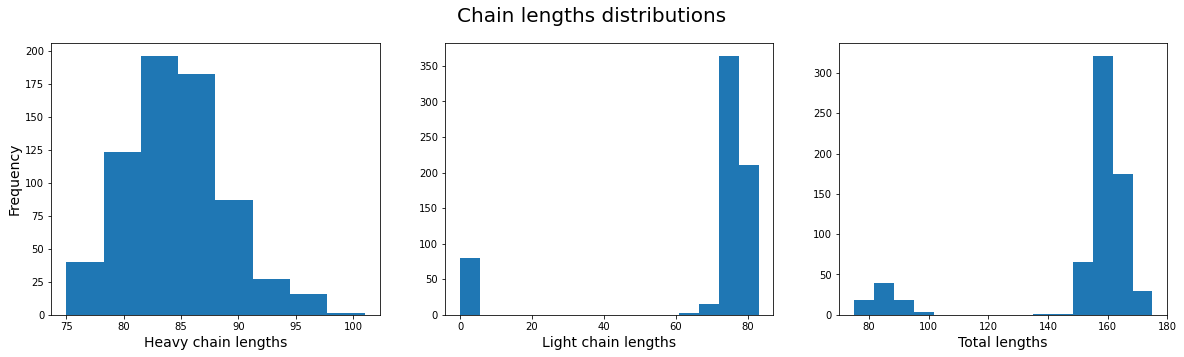

In [5]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

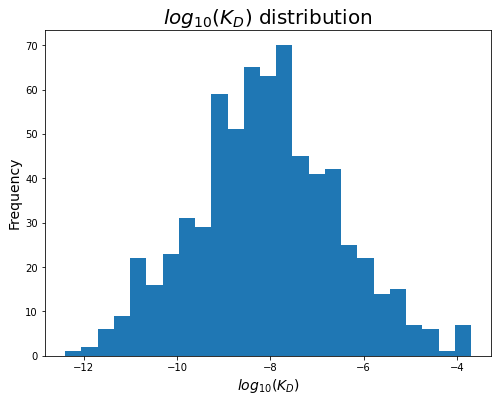

In [6]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

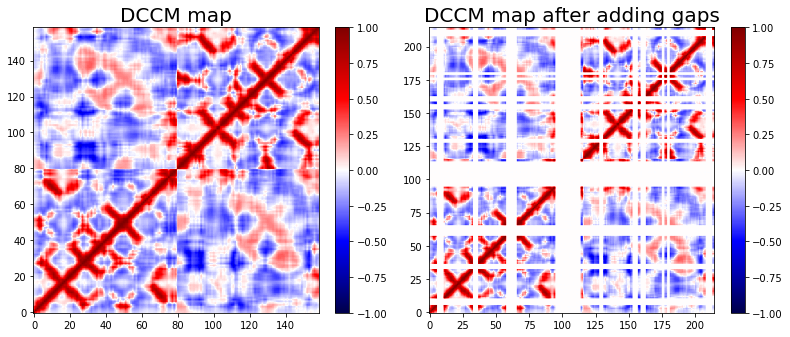

In [7]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [8]:
# The test set is generated
train_x, test_x, train_y, test_y = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [9]:
# Hyperparameters
n_filters = 4
filter_size = 4
pooling_size = 1
learning_rate = 0.00027253018778842

# Defining the model, optimiser and loss function
model = NormalModeAnalysisCNN(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss() #-PearsonCorrCoef()
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
NormalModeAnalysisCNN(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=179776, out_features=1, bias=False)
)


In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [59]:
count_parameters(model)

179844

In [60]:
#{'learning_rate': 0.00027253018778843, 'n_max_epochs': 65, 'pooling_size': 1, 'filter_size': 4, 'n_filters': 4}
#{'learning_rate': 0.0008657756272162166, 'n_max_epochs': 82, 'pooling_size': 1, 'filter_size': 5, 'n_filters': 1}. Best is trial 30 with value: 1.0617385705312092.

# Training

In [61]:
train_losses = []
test_losses = []

In [18]:
n_max_epochs = 250
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor([[-8.8503]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.0505]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.5831]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.5115]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.2583]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9993]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.9187]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9131]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.4921]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.5232]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8434]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.3569]], grad_fn=<MmBack

tensor([[-9.0949]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.0380]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.8002]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6663]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.4070]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.8325]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.4475]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.1854]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.6080]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.7137]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9549]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.4298]], grad_fn=<MmBack

tensor([[-8.8045]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-6.9439]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7209]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.4849]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.3294]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.7148]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.3957]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9823]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.6263]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.7780]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9902]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.3359]], grad_fn=<MmBack

tensor([[-8.8897]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.0365]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4288]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.5650]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.5119]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9799]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.6355]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.1493]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.5815]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.0087]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9396]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.2918]], grad_fn=<MmBack

tensor([[-9.0658]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-6.9904]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4703]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.5549]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.4851]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9179]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.1560]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2054]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.7188]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.6408]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9299]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.2592]], grad_fn=<MmBack

tensor([[-9.2026]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-6.8916]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7518]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6445]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.2722]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.8147]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5055]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.1083]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.5618]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.7171]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9892]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.2303]], grad_fn=<MmBack

tensor([[-9.1898]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.0630]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7110]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6956]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.3519]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.8536]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5200]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.0034]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.4713]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.6221]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.4919]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.2670]], grad_fn=<MmBack

tensor([[-8.9476]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.0749]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7523]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.7420]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.4809]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.1547]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5553]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.0542]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.6687]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.6762]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.2306]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.6273]], grad_fn=<MmBack

tensor([[-9.1089]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.1375]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.6456]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6133]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.2151]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.8981]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5082]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.8615]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.4902]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.6622]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1323]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.2297]], grad_fn=<MmBack

In [13]:
#optimiser.param_groups[0]['lr'] = 2e-3

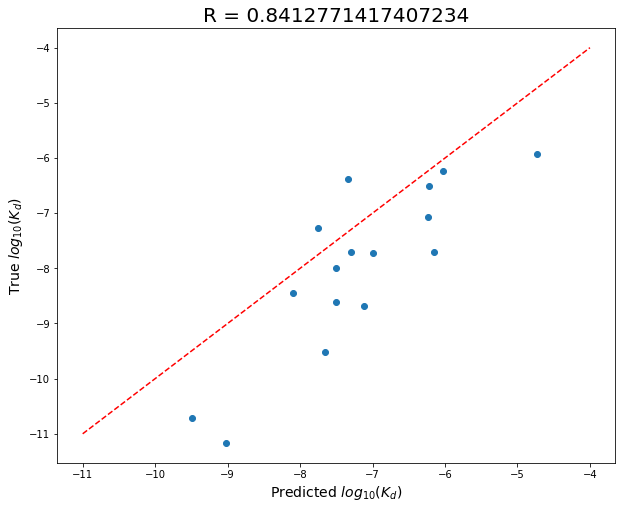

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(output_test.detach().numpy(), y_test[:,0].detach().numpy())
corr = np.corrcoef(output_test.detach().numpy().T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

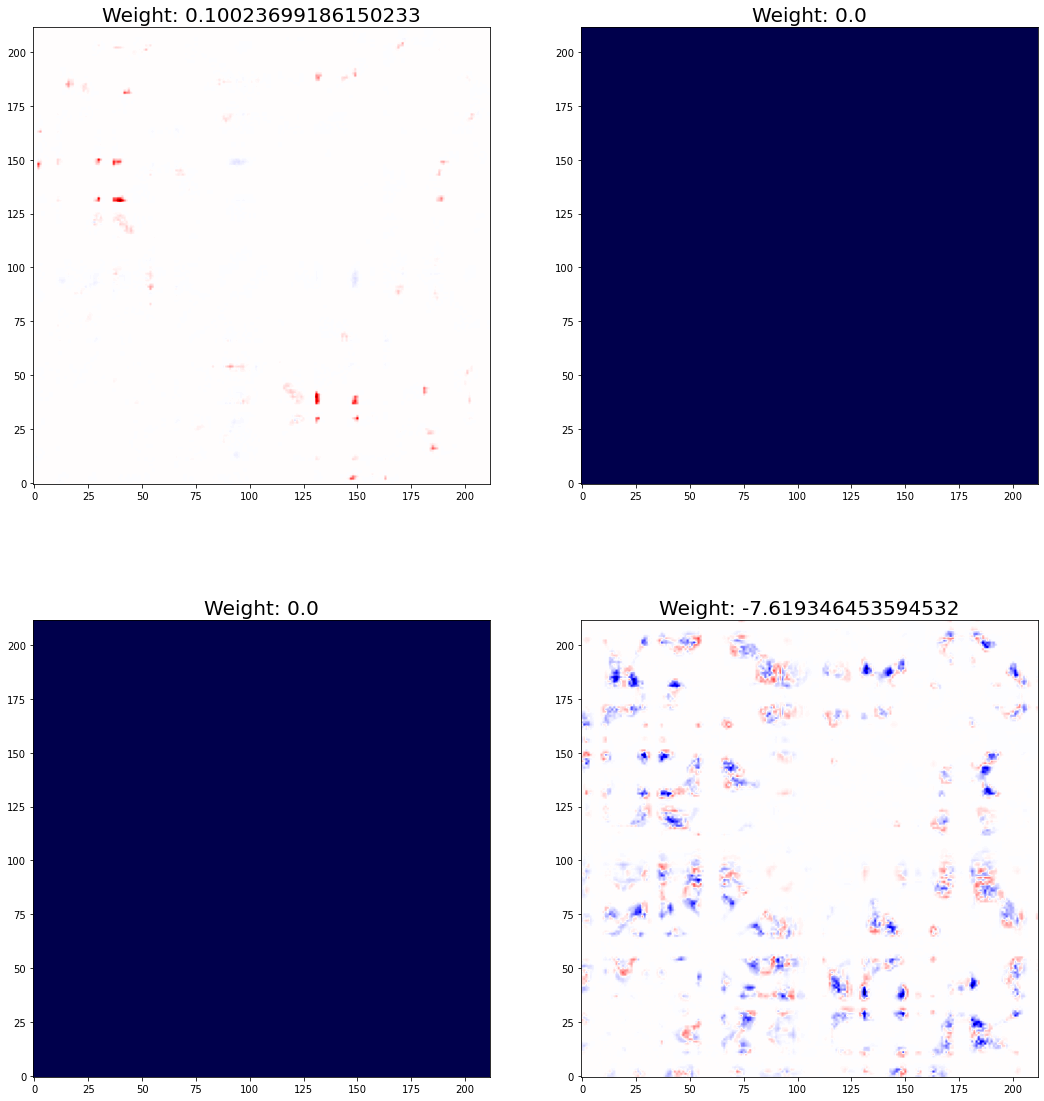

In [15]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[i,j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[i,j].set_title('Weight: '+str(im_.sum()), size=title_size)

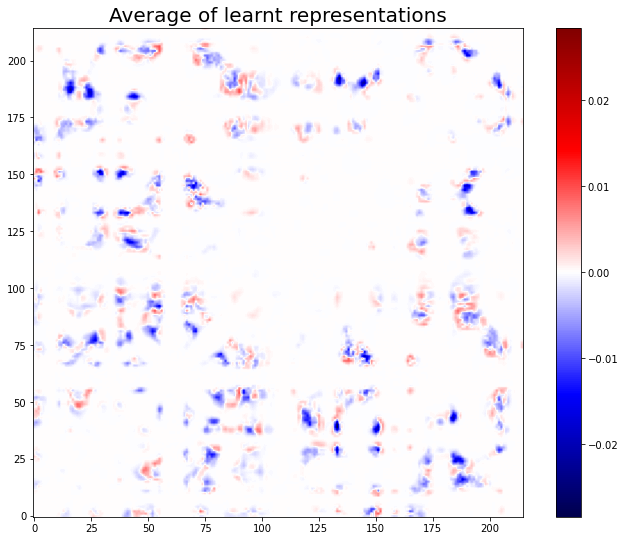

In [16]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(cv2.resize(learnt_filter, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

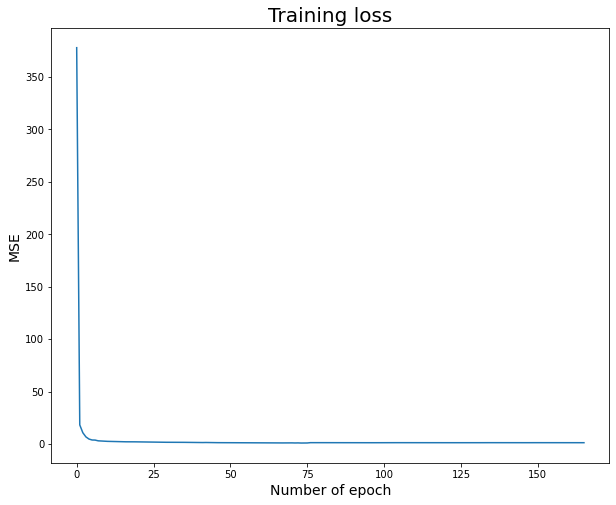

In [28]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

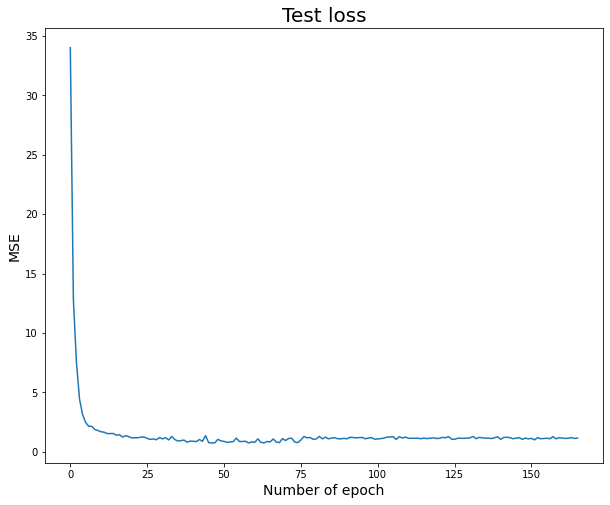

In [29]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i].detach().numpy() for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

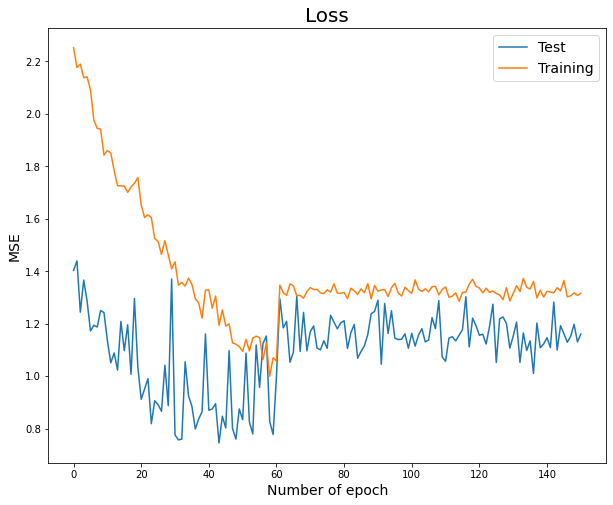

In [30]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[15:][i].detach().numpy() for i in range(len(test_losses[15:]))])
plt.plot([train_losses[15:][i] for i in range(len(train_losses[15:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [55]:
model(train_x[40:80])[0]

tensor([[ -8.8336],
        [ -7.7581],
        [ -8.3699],
        [ -6.5236],
        [ -7.4694],
        [ -7.1855],
        [ -7.7815],
        [ -8.0967],
        [ -9.8397],
        [ -7.3619],
        [ -8.1606],
        [ -8.9225],
        [ -8.9993],
        [ -8.8087],
        [ -8.4357],
        [ -8.4496],
        [ -7.4369],
        [ -7.3454],
        [ -8.0265],
        [ -8.4890],
        [ -7.9807],
        [-10.1439],
        [ -7.4123],
        [ -8.6146],
        [ -8.0228],
        [ -7.8637],
        [ -6.7537],
        [ -8.0850],
        [ -7.4178],
        [ -9.5446],
        [ -6.3511],
        [ -6.1408],
        [ -7.7777],
        [-10.3307],
        [ -5.5028],
        [ -6.6139],
        [ -8.0653],
        [ -5.3336],
        [ -7.5324],
        [ -6.1695]], grad_fn=<MmBackward0>)

In [56]:
train_y[40:80]

tensor([[ -9.0269],
        [ -6.7905],
        [ -9.1759],
        [ -5.3098],
        [ -7.0269],
        [ -6.8539],
        [ -5.7959],
        [ -8.4815],
        [-10.7447],
        [ -8.7645],
        [ -8.5935],
        [ -9.5686],
        [-11.6021],
        [ -8.3010],
        [ -8.2218],
        [ -7.0605],
        [ -6.7799],
        [ -7.7212],
        [ -8.2218],
        [ -8.1871],
        [ -8.1141],
        [-11.2441],
        [ -7.6576],
        [ -9.5376],
        [ -7.3279],
        [ -6.6198],
        [ -6.5391],
        [ -7.8539],
        [ -7.7696],
        [ -8.2518],
        [ -7.0000],
        [ -5.3279],
        [ -6.3872],
        [-10.2676],
        [ -5.0555],
        [ -5.7959],
        [ -8.2147],
        [ -4.6198],
        [ -7.5528],
        [ -6.2218]])

In [36]:
##### Uncomment the following lines to save a checkpoint

#path = '../checkpoints/model_' + regions + '_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
#save_checkpoint(path, model, optimiser, train_losses, test_losses)
#np.save('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [10]:
from nmacnn.utils.torch_utils import load_checkpoint

path = '../checkpoints/model_' + regions + '_epochs_' + str(76) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model,_,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
